### pitstop dataset

based on:8./pitstop_dataset-v2.ipynb

build a pitstop dataset across all the oval races

gap distribution analysis. 
+ comparison with normalized histgram
+ no yellow flag, pure racing stint
+ yellow flag raised, pitstop at green flag
+ yellow flag raised, pitstop at caution flag

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


## Load Data

In [2]:
import os
os.getcwd()

'/scratch_hdd/hpda/indycar/notebook/14.StatusModelII'

In [3]:
# make indy car completed_laps dataset
# car_number, completed_laps, rank, elapsed_time, rank_diff, elapsed_time_diff 
def make_cl_data(dataset):

    # pick up data with valid rank
    rankdata = dataset.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')

    # resort by car_number, lap
    uni_ds = rankdata.sort_values(by=['car_number', 'completed_laps', 'elapsed_time'], ascending=True)    
    #uni_ds = uni_ds.drop(["unique_id", "best_lap", "current_status", "track_status", "lap_status",
    #                  "laps_behind_leade","laps_behind_prec","overall_rank","pit_stop_count",
    #                  "last_pitted_lap","start_position","laps_led"], axis=1)
    
    uni_ds = uni_ds.drop(["unique_id", "best_lap", 
                      "laps_behind_leade","laps_behind_prec","overall_rank","pit_stop_count",
                      "last_pitted_lap","start_position","laps_led"], axis=1)
        
    carnumber = set(uni_ds['car_number'])
    print('cars:', carnumber)
    print('#cars=', len(carnumber))
   
    # faster solution , uni_ds already sorted by car_number and lap
    uni_ds['rank_diff'] = uni_ds['rank'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['rank_diff'][mask] = 0
    
    uni_ds['time_diff'] = uni_ds['elapsed_time'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['time_diff'][mask] = 0
    
    #df = uni_ds[['car_number','completed_laps','rank','elapsed_time','rank_diff','time_diff']]
    #df = uni_ds[['car_number','completed_laps','rank',
    #             'rank_diff','time_diff',"current_status", "track_status", "lap_status",'elapsed_time']]
    
    df = uni_ds[['car_number','completed_laps','time_diff','rank','track_status', 'lap_status','elapsed_time']]
    
    return df

def make_lapstatus_data(dataset):
    final_lap = max(dataset.completed_laps)
    total_laps = final_lap + 1

    # get records for the cars that finish the race
    completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
    completed_car_count = len(completed_car_numbers)

    print('count of completed cars:', completed_car_count)
    print('completed cars:', completed_car_numbers)
    
    #pick up one of them
    onecar = dataset[dataset['car_number']==completed_car_numbers[0]]
    onecar = onecar.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    return onecar[['completed_laps','track_status']]
    

In [4]:
def load_data(event, year=0):
    #inputfile = '../data/final/C_'+ event +'-' + year + '-final.csv'
    if year>0:
        inputfile = '../data/final/C_'+ event +'-' + year + '.csv'
    else:
        inputfile = '../data/final/C_'+ event +'.csv'
    
    #outputprefix = year +'-' + event + '-'
    dataset = pd.read_csv(inputfile)
    #dataset.info(verbose=True)    
    
    final_lap = max(dataset.completed_laps)
    total_laps = final_lap + 1

    # get records for the cars that finish the race
    completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
    completed_car_count = len(completed_car_numbers)

    print('count of completed cars:', completed_car_count)
    print('completed cars:', completed_car_numbers)

    #make a copy
    alldata = dataset.copy()
    dataset = dataset[dataset['car_number'].isin(completed_car_numbers)]
    rankdata = alldata.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    
    cldata = make_cl_data(dataset)
    flagdata = make_lapstatus_data(dataset)
    acldata = make_cl_data(alldata)

    return alldata, rankdata, acldata, flagdata

### bulid the dataset

In [5]:
def get_stagedata(TRIM=2):
    """
    input: acldata, rankdata, the whole dataset
    output: stagedata['car_number','stage','start_lap','end_lap','start_rank','end_rank','yellowflag_raised']
    """
    carlist = set(acldata['car_number'])
    data = []
    for curcarno in carlist:
        car = acldata[acldata['car_number']==curcarno]
        #print(car['time_diff'].describe())

        cols=['completed_laps','rank','car_number','lap_status','track_status',
        'pit_stop_count','current_status','start_position']
        colid={key:idx for idx, key in enumerate(cols)}

        cardata = rankdata[rankdata['car_number'] == curcarno]

        carstatus = [[row[0], row[1],row[2],row[3],row[4],row[5],row[6],row[7]] for row in cardata[
            ['completed_laps','rank','car_number','lap_status','track_status',
            'pit_stop_count','current_status','start_position']].values]

        pits=[]
        yellowflags=[]
        lastflag = 'x'
        
        stage = 0
        start_lap = 0
        pit_lap = -1
        pit_in_caution = 0
        yellowflag_raised = 0
        for row in carstatus:
            lap = int(row[colid['completed_laps']])
            
            if lap==0:
                #hex2int
                start_rank = int(row[colid['start_position']], 16)     
            
            if row[colid['track_status']]=='Y':
                yellowflag_raised = 1
                if lastflag != 'Y':       
                    #start
                    yellowflags.append(lap)
            else:
                if lastflag == 'Y':       
                    #end
                    yellowflags.append(lap)        
            lastflag = row[colid['track_status']]
            
            if row[colid['lap_status']]=='P' and row[colid['current_status']]=='Active':
                pits.append(lap)
                end_lap = lap - TRIM
                end_rank = carstatus[end_lap][colid['rank']]
                
                #pit_lap = lap  #current is pit lap
                
                #redefine pit_lap as the previous caution_lap
                #pit_lap = yellowflags[-1]
                #pit_in_caution = 1 if row[colid['track_status']]=='Y' else 0
                if row[colid['track_status']]=='Y':
                    pit_lap = yellowflags[-1]
                    pit_in_caution = 1
                else:
                    pit_lap = lap
                    pit_in_caution = 0
                
                #add one record
                #stagedata['car_number','stage','start_lap','end_lap','start_rank','end_rank','yellowflag_raised']
                data.append([curcarno,stage,start_lap, end_lap, pit_lap, pit_in_caution, 
                             start_rank, end_rank,yellowflag_raised])
                # prepare for the next
                stage += 1
                start_lap = end_lap  # end_lap + 1?
                start_rank = end_rank
                yellowflag_raised = 1 if lastflag=='Y' else 0

        #final
        end_lap = carstatus[-1][colid['completed_laps']]
        end_rank = carstatus[-1][colid['rank']]
        #add one record
        #stagedata['car_number','stage','start_lap','end_lap',pit_lap, pit_in_caution,'start_rank','end_rank']
        #data.append([curcarno,stage,start_lap, end_lap, pit_lap, pit_in_caution, start_rank, end_rank])
        
        #pit lap
        pits = np.array(pits)
        #start, end lap
        #
        yellowflags = np.array(yellowflags)
        if (yellowflags.shape[0] % 2)==1:
            print('crash?:carno=', curcarno)
            yellowflags = []
        else:
            yellowflags = np.array(yellowflags).reshape((-1,2))  
            
    data = np.array(data)
    #['car_number','stage','start_lap','end_lap',pit_lap, pit_in_caution,'start_rank','end_rank']
    df = pd.DataFrame({'car_number': data[:, 0], 'stage': data[:, 1],'start_lap': data[:, 2],
                      'end_lap': data[:, 3], 'pit_lap': data[:, 4], 'pit_in_caution': data[:, 5],
                       'start_rank': data[:, 6],'end_rank': data[:, 7],'yellowflag_raised':data[:,8]})
    return df, data

### events

In [37]:
def extract_pitstop_features(stagedata):
    """
    input: (alldata, rankdata, acldata, flagdata)
    
    output:
        eventid
        car_number
        pit_id          ; 
    
        lap_number   ; lap_number of this pitstop
        lap_time     ; lap time for this pitstop lap
        total_laps    ; lap distance from the last pit(or start lap)
        total_cautionlaps ; caution laps

        pit_in_caution   ; 1/0
        caution_distance ; lap distance from the start lap of current caution period
    """
    #eventid = 0
    cols=['lap_distance','start_lap','caution_distance',
             'eventid','car_number','stageid',
             'pit_in_caution', 'yellowflag_raised',
             'start_position', 'start_rank', 'end_rank']
    
    pitrec = []
    for event in stagedata.keys():
        
        eventid = events_id[event]
        
        alldata, rankdata, acldata, flagdata = stagedata[event]
        carlist = set(acldata['car_number'])
        laplist = set(acldata['completed_laps'])
        totalcars = len(carlist)
        totallaps = len(laplist)

        for carno in carlist:
            
            thiscar = acldata[acldata['car_number']==carno]
            
            #scan the data of this car
            cautionlap_cnt = 0
            lap_cnt = 0
            last_cautionlap_start = -1
            pit_id = 0
            for idx in range(len(thiscar)):
                
                lap_number = thiscar.iloc[idx].completed_laps
                
                if(thiscar.iloc[idx].lap_status == 'P'):
                    if(thiscar.iloc[idx].track_status == 'Y'):
                        pit_oncaution = 1
                        if last_cautionlap_start>0:
                            pit_oncaution_len = lap_number - last_cautionlap_start
                        else:
                            pit_oncaution_len = 0    
                    else:
                        pit_oncaution = 0
                        pit_oncaution_len = 0
                    #a new pit record
                    laptime = thiscar.iloc[idx].time_diff
                    #['eventid', 'carno','pit_id', 'lap_number', 'time_diff',
                    # 'lap_cnt','cautionlap_cnt','pit_oncaution_len','pit_oncaution']
                    pitrec.append([eventid, carno,pit_id, lap_number, laptime,
                          lap_cnt,cautionlap_cnt,pit_oncaution_len,pit_oncaution])
                    
                    #reset
                    if not pit_oncaution:
                        last_cautionlap_start = -1    
                        
                    cautionlap_cnt = 0
                    lap_cnt = 0
                    
                    pit_id += 1
                    
                else:
                    if(thiscar.iloc[idx].track_status == 'Y'):
                        cautionlap_cnt += 1
                        if (thiscar.iloc[idx-1].track_status != 'Y'):
                            last_cautionlap_start = lap_number
                    else:
                        last_cautionlap_start = -1
                            
                    lap_cnt += 1
                    
        # push this event into stage dataframe
        print('event=%s, records=%d'%(event, len(pitrec)))
    df = pd.DataFrame(pitrec,columns=['eventid', 'carno','pit_id', 'lap_number', 
                     'lap_time',
                     'lap_cnt','cautionlap_cnt','pit_oncaution_len','pit_oncaution'])
        
    return df



### load data

In [38]:
stagedata = {}
global_carids = {}
traindata = None
cur_carid = 0
#years = ['2011','2012','2013', '2014', '2015', '2016', '2017']
years = ['2012','2013', '2014', '2015', '2016', '2017']
years = ['2012','2013','2014','2015','2016','2017']
years = ['2011']
years = ['2013','2014','2015','2016','2017','2018']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}
dbid = f'Indy500_{years[0]}_{years[-1]}'



traindata = None
for event in events:
    #alldata, rankdata, acldata, flagdata
    stagedata[event] = load_data(event)
    
    alldata, rankdata, acldata, flagdata = stagedata[event]
    carlist = set(acldata['car_number'])
    laplist = set(acldata['completed_laps'])
    print('%s: carno=%d, lapnum=%d'%(event, len(carlist), len(laplist)))


count of completed cars: 19
completed cars: [11 26  1 25 19  3  2 77 83 20 22  8 14  9 18 55 78  5 12]
cars: {1, 2, 3, 5, 8, 9, 11, 12, 77, 14, 78, 18, 19, 20, 83, 22, 55, 25, 26}
#cars= 19
count of completed cars: 19
completed cars: [11 26  1 25 19  3  2 77 83 20 22  8 14  9 18 55 78  5 12]
cars: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22, 25, 26, 27, 41, 55, 60, 63, 77, 78, 81, 83, 91, 98}
#cars= 33
Indy500-2013: carno=33, lapnum=201
count of completed cars: 20
completed cars: [28  3 25 34  2 26 11 12 22 21 16 77 68  5 17 33 18  8 14 98]
cars: {33, 2, 3, 34, 5, 68, 98, 8, 11, 12, 77, 14, 16, 17, 18, 21, 22, 25, 26, 28}
#cars= 20


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


count of completed cars: 20
completed cars: [28  3 25 34  2 26 11 12 22 21 16 77 68  5 17 33 18  8 14 98]
cars: {2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 28, 33, 34, 41, 63, 67, 68, 77, 83, 91, 98}
#cars= 33
Indy500-2014: carno=33, lapnum=201
count of completed cars: 20
completed cars: [ 2  1 83  9 15 27  3  6 21 22 11  5 14 24 28 98 48  7 29 26]
cars: {1, 2, 3, 98, 5, 6, 7, 9, 11, 14, 15, 48, 83, 21, 22, 24, 26, 27, 28, 29}
#cars= 20
count of completed cars: 20
completed cars: [ 2  1 83  9 15 27  3  6 21 22 11  5 14 24 28 98 48  7 29 26]
cars: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 32, 41, 43, 48, 63, 83, 88, 98}
#cars= 33
Indy500-2015: carno=33, lapnum=201
count of completed cars: 17
completed cars: [98 26 21 10 42  6  5  9 11 12  3 77 27 15  8 41 35]
cars: {98, 3, 35, 5, 6, 8, 9, 10, 11, 12, 41, 42, 15, 77, 21, 26, 27}
#cars= 17
count of completed cars: 17
completed cars: [98 26 21 10 42  6 

In [39]:
df = extract_pitstop_features(stagedata)

event=Indy500-2013, records=198
event=Indy500-2014, records=426
event=Indy500-2015, records=624
event=Indy500-2016, records=883
event=Indy500-2017, records=1131
event=Indy500-2018, records=1323


In [10]:
#stagedf0.reset_index(inplace=True)
#stagedf = update_neighbor(stagedf0, carindex) 

In [16]:
df.head(10)

,eventid,carno,pit_id,lap_number,lap_time,lap_cnt,cautionlap_cnt,pit_oncaution_len,pit_oncaution
0,0,1,0,31,52.8474,31,3,0,0
1,0,1,1,58,93.6363,26,9,1,1
2,0,1,2,90,53.6327,31,2,0,0
3,0,1,3,122,52.4165,31,0,0,0
4,0,1,4,152,52.1289,29,0,0,0
5,0,1,5,181,51.6569,28,0,0,0
6,0,2,0,32,54.6129,32,3,0,0
7,0,2,1,39,107.2050,6,5,5,1
8,0,2,2,58,91.2985,18,4,1,1
9,0,2,3,90,53.8106,31,2,0,0


In [82]:
df[(df['eventid']==5) & (df['carno']==12)]

,eventid,carno,pit_id,lap_number,lap_time,lap_cnt,cautionlap_cnt,pit_oncaution_len,pit_oncaution
1171,5,12,0,32,56.1652,32,0,0,0
1172,5,12,1,50,116.1604,17,2,2,1
1173,5,12,2,94,52.4746,43,14,0,0
1174,5,12,3,129,53.4746,34,0,0,0
1175,5,12,4,171,52.4221,41,20,0,0


In [15]:
df.to_csv('pitstop-indy2013-2018.csv')

### pitstop analysis

In [44]:
car12 = df[df['carno']==16]
#np.sort(car12[['lap_cnt','lap_time]].values)
st = car12.sort_values(by=['lap_time'], ascending=True)    
st[['lap_cnt','lap_time']].values

array([[ 31.    ,  52.7837],
       [ 29.    ,  52.8092],
       [  3.    ,  53.2584],
       [ 29.    ,  64.3353],
       [ 27.    ,  67.2831],
       [ 30.    ,  67.9975],
       [ 30.    ,  68.4124],
       [ 24.    ,  68.8419],
       [ 30.    ,  69.0098],
       [ 30.    ,  69.6358],
       [ 28.    ,  70.0906],
       [ 30.    ,  72.7372],
       [ 19.    ,  76.55  ],
       [ 24.    ,  83.9182],
       [ 32.    ,  90.7599],
       [ 32.    ,  96.3951],
       [  1.    ,  99.4693],
       [ 19.    , 103.4598],
       [ 16.    , 105.5002],
       [ 24.    , 107.0724],
       [  9.    , 111.8249],
       [ 28.    , 112.1609],
       [ 20.    , 116.8009],
       [ 15.    , 118.4533],
       [ 29.    , 121.6555],
       [ 32.    , 138.9745],
       [  5.    , 140.6742],
       [ 21.    , 143.5023],
       [ 25.    , 184.1374],
       [ 35.    , 373.3867]])

In [45]:
car12[(car12['pit_oncaution']==0) & (car12['lap_time']<80)]

,eventid,carno,pit_id,lap_number,lap_time,lap_cnt,cautionlap_cnt,pit_oncaution_len,pit_oncaution
80,0,16,4,95,53.2584,3,0,0,0
81,0,16,5,120,68.8419,24,0,0,0
82,0,16,6,151,72.7372,30,0,0,0
83,0,16,7,180,70.0906,28,0,0,0
281,1,16,0,30,69.0098,30,0,0,0
282,1,16,1,61,67.9975,30,0,0,0
283,1,16,2,92,68.4124,30,0,0,0
284,1,16,3,120,67.2831,27,0,0,0
720,3,16,0,30,69.6358,30,0,0,0
727,3,16,7,193,64.3353,29,0,0,0


In [46]:
car12[car12['lap_time']>80]

,eventid,carno,pit_id,lap_number,lap_time,lap_cnt,cautionlap_cnt,pit_oncaution_len,pit_oncaution
76,0,16,0,5,140.6742,5,1,1,1
77,0,16,1,38,138.9745,32,4,3,1
78,0,16,2,58,103.4598,19,5,1,1
79,0,16,3,91,90.7599,32,2,0,0
285,1,16,4,153,96.3951,32,4,4,1
286,1,16,5,170,105.5002,16,5,2,1
287,1,16,6,192,143.5023,21,9,1,1
722,3,16,2,66,118.4533,15,5,2,1
723,3,16,3,96,121.6555,29,11,3,1
724,3,16,4,117,116.8009,20,10,3,1


In [47]:
car12[car12['pit_oncaution']==1]

,eventid,carno,pit_id,lap_number,lap_time,lap_cnt,cautionlap_cnt,pit_oncaution_len,pit_oncaution
76,0,16,0,5,140.6742,5,1,1,1
77,0,16,1,38,138.9745,32,4,3,1
78,0,16,2,58,103.4598,19,5,1,1
285,1,16,4,153,96.3951,32,4,4,1
286,1,16,5,170,105.5002,16,5,2,1
287,1,16,6,192,143.5023,21,9,1,1
721,3,16,1,50,76.5500,19,4,4,1
722,3,16,2,66,118.4533,15,5,2,1
723,3,16,3,96,121.6555,29,11,3,1
724,3,16,4,117,116.8009,20,10,3,1


In [60]:
df[df['cautionlap_cnt']==0]

,eventid,carno,pit_id,lap_number,lap_time,lap_cnt,cautionlap_cnt,pit_oncaution_len,pit_oncaution
3,0,1,3,122,52.4165,31,0,0,0
4,0,1,4,152,52.1289,29,0,0,0
5,0,1,5,181,51.6569,28,0,0,0
10,0,2,4,112,55.6211,21,0,0,0
11,0,2,5,143,53.4679,30,0,0,0
...,...,...,...,...,...,...,...,...,...
1308,5,66,4,136,65.9408,31,0,0,0
1310,5,88,0,32,67.5144,32,0,0,0
1314,5,88,4,124,65.5637,30,0,0,0
1318,5,98,0,32,55.3328,32,0,0,0


In [62]:
df[(df['cautionlap_cnt']==0) &(df['lap_time']<80)].lap_time

,eventid,carno,pit_id,lap_number,lap_time,lap_cnt,cautionlap_cnt,pit_oncaution_len,pit_oncaution
3,0,1,3,122,52.4165,31,0,0,0
4,0,1,4,152,52.1289,29,0,0,0
5,0,1,5,181,51.6569,28,0,0,0
10,0,2,4,112,55.6211,21,0,0,0
11,0,2,5,143,53.4679,30,0,0,0
...,...,...,...,...,...,...,...,...,...
1308,5,66,4,136,65.9408,31,0,0,0
1310,5,88,0,32,67.5144,32,0,0,0
1314,5,88,4,124,65.5637,30,0,0,0
1318,5,98,0,32,55.3328,32,0,0,0


In [70]:
sorted(df[(df['cautionlap_cnt']==0) &(df['lap_time']<55)].lap_cnt)

[1,
 1,
 1,
 1,
 2,
 3,
 3,
 4,
 5,
 14,
 20,
 22,
 23,
 23,
 24,
 24,
 24,
 25,
 25,
 26,
 27,
 27,
 27,
 27,
 27,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 33,
 33,
 33,
 33,
 33,
 34,
 34,
 34,
 34,
 34,
 35]

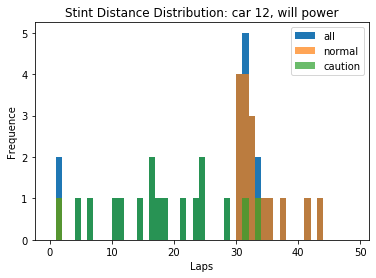

In [59]:
# car 12, will power
bins=np.arange(50)
car12 = df[df['carno']==12]
nlap = car12[car12['lap_time']<80].lap_cnt
nlap = car12.lap_cnt
clap = car12[car12['pit_oncaution']==0].lap_cnt
#clap2 = car12[(car12['pit_oncaution']==1) & (car12['lap_time']<80)].lap_cnt
clap2 = car12[(car12['pit_oncaution']==1)].lap_cnt
plt.hist(nlap,bins= bins, label='all')
plt.hist(clap,bins= bins,  alpha=0.7,label='normal')
plt.hist(clap2,bins= bins,  alpha=0.7,label='caution')
plt.xlabel('Laps')
plt.ylabel('Frequence')
plt.title('Stint Distance Distribution: car 12, will power')
plt.legend(prop={'size': 10})

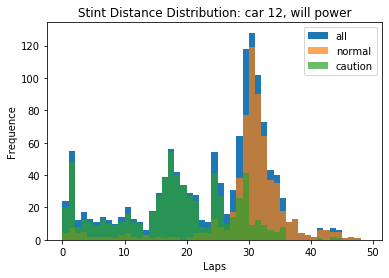

In [55]:
# car 12, will power
bins=np.arange(50)
car12 = df
nlap = car12[car12['lap_time']<80].lap_cnt
nlap = car12.lap_cnt
clap = car12[car12['pit_oncaution']==0].lap_cnt
#clap2 = car12[(car12['pit_oncaution']==1) & (car12['lap_time']<80)].lap_cnt
clap2 = car12[(car12['pit_oncaution']==1)].lap_cnt
plt.hist(nlap,bins= bins, label='all')
plt.hist(clap,bins= bins,  alpha=0.7,label='normal')
plt.hist(clap2,bins= bins,  alpha=0.7,label='caution')
plt.xlabel('Laps')
plt.ylabel('Frequence')
plt.title('Stint Distance Distribution: car 12, will power')
plt.legend(prop={'size': 10})

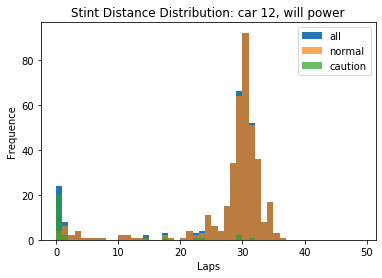

In [61]:
car12 = df[df['cautionlap_cnt']==0]
nlap = car12.lap_cnt
clap = car12[car12['pit_oncaution']==0].lap_cnt
#clap2 = car12[(car12['pit_oncaution']==1) & (car12['lap_time']<80)].lap_cnt
clap2 = car12[(car12['pit_oncaution']==1)].lap_cnt
plt.hist(nlap,bins= bins, label='all')
plt.hist(clap,bins= bins,  alpha=0.7,label='normal')
plt.hist(clap2,bins= bins,  alpha=0.7,label='caution')
plt.xlabel('Laps')
plt.ylabel('Frequence')
plt.title('Stint Distance Distribution: car 12, will power')
plt.legend(prop={'size': 10})

In [80]:
print('normal:', len(df[(df['cautionlap_cnt']==0) &(df['lap_time']<80)]),
      'total:', len(df[(df['cautionlap_cnt']==0)]),
    'ratio:',  len(df[(df['cautionlap_cnt']==0) &(df['lap_time']<80)]) *1.0/len(df[(df['cautionlap_cnt']==0)])
     )
print('normal:', len(df[(df['cautionlap_cnt']==0) & (df['lap_time']<80) & (df['pit_oncaution']==0)]),
      'total:', len(df[(df['cautionlap_cnt']==0) & (df['pit_oncaution']==0)]),
    'ratio:',  len(df[(df['cautionlap_cnt']==0) & (df['lap_time']<80) & (df['pit_oncaution']==0)]) *1.0/
              len(df[(df['cautionlap_cnt']==0) &( df['pit_oncaution']==0)])
     )


normal: 364 total: 411 ratio: 0.8856447688564477
normal: 360 total: 382 ratio: 0.9424083769633508


normal: 364 total: 411 ratio: 0.8856447688564477


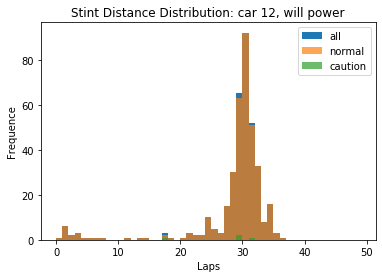

In [77]:
car12 =df[(df['cautionlap_cnt']==0) &(df['lap_time']<80)]

nlap = car12.lap_cnt
clap = car12[car12['pit_oncaution']==0].lap_cnt
#clap2 = car12[(car12['pit_oncaution']==1) & (car12['lap_time']<80)].lap_cnt
clap2 = car12[(car12['pit_oncaution']==1)].lap_cnt
plt.hist(nlap,bins= bins, label='all')
plt.hist(clap,bins= bins,  alpha=0.7,label='normal')
plt.hist(clap2,bins= bins,  alpha=0.7,label='caution')
plt.xlabel('Laps')
plt.ylabel('Frequence')
plt.title('Stint Distance Distribution: car 12, will power')
plt.legend(prop={'size': 10})

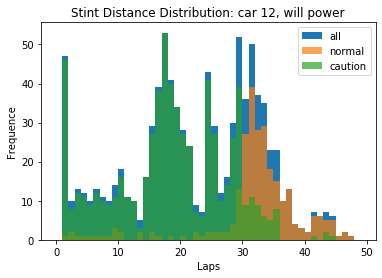

In [75]:
car12 = df[df['cautionlap_cnt']>0]
nlap = car12.lap_cnt
clap = car12[car12['pit_oncaution']==0].lap_cnt
#clap2 = car12[(car12['pit_oncaution']==1) & (car12['lap_time']<80)].lap_cnt
clap2 = car12[(car12['pit_oncaution']==1)].lap_cnt
plt.hist(nlap,bins= bins, label='all')
plt.hist(clap,bins= bins,  alpha=0.7,label='normal')
plt.hist(clap2,bins= bins,  alpha=0.7,label='caution')
plt.xlabel('Laps')
plt.ylabel('Frequence')
plt.title('Stint Distance Distribution: car 12, will power')
plt.legend(prop={'size': 10})

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  del sys.path[0]


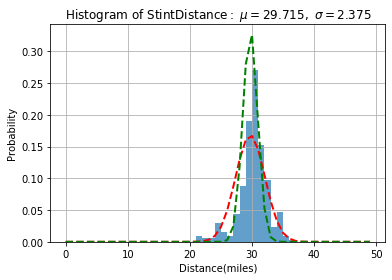

In [74]:
# fit the data with normal distribution
from scipy.stats import norm
import matplotlib.mlab as mlab

#get all data
cars =df[(df['cautionlap_cnt']==0) & (df['lap_time']<80) & (df['lap_cnt']>20)]
normal_dist = cars.lap_cnt

# best fit of data
(mu, sigma) = norm.fit(normal_dist)

# the histogram of the data
n, hist_bins, patches = plt.hist(normal_dist, bins,normed=1, alpha=0.7)

# add a 'best fit' line
y = norm.pdf( hist_bins, mu, sigma)
l = plt.plot(hist_bins, y, 'r--', linewidth=2)


y = norm.pdf( hist_bins, mu, sigma/2)
l = plt.plot(hist_bins, y, 'g--', linewidth=2)


#plot
plt.xlabel('Distance(miles)')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ StintDistance:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)


### conclusion

+ caution laps are not predictable
+ there are small portion of pitstop caused by failures, around 6%-12%.
+ when all caution laps are excluded, the normal pit stops follow a bell-curve. 
  
  condition as: "(df['cautionlap_cnt']==0) & (df['lap_time']<80) & (df['pit_oncaution']==0)"

In [21]:
events_id

{'Indy500-2013': 0,
 'Indy500-2014': 1,
 'Indy500-2015': 2,
 'Indy500-2016': 3,
 'Indy500-2017': 4,
 'Indy500-2018': 5}

In [14]:
df[(df['eventid']==0) & (df['carno']==16)]

,eventid,carno,pit_id,lap_number,lap_time,lap_cnt,cautionlap_cnt,pit_oncaution_len,pit_oncaution
76,0,16,0,5,140.6742,5,1,1,1
77,0,16,1,38,138.9745,32,4,3,1
78,0,16,2,58,103.4598,19,5,1,1
79,0,16,3,91,90.7599,32,2,0,0
80,0,16,4,95,53.2584,3,0,0,0
81,0,16,5,120,68.8419,24,0,0,0
82,0,16,6,151,72.7372,30,0,0,0
83,0,16,7,180,70.0906,28,0,0,0


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 1322
Data columns (total 9 columns):
eventid              1323 non-null int64
carno                1323 non-null int64
pit_id               1323 non-null int64
lap_number           1323 non-null int64
lap_time             1323 non-null float64
lap_cnt              1323 non-null int64
cautionlap_cnt       1323 non-null int64
pit_oncaution_len    1323 non-null int64
pit_oncaution        1323 non-null int64
dtypes: float64(1), int64(8)
memory usage: 93.1 KB
